# Vodafone Customer Churn Prediction

This project demonstrates advanced machine learning techniques to predict customer churn for Vodafone subscribers. The goal is to identify customers who are likely to leave the service, enabling proactive retention strategies with measurable business impact.

**Key Objectives:**
- Build a robust churn prediction model using CatBoost
- Handle class imbalance (6.4% churn rate)
- Provide actionable business insights
- Demonstrate ROI potential for retention campaigns

**Project Structure:**
1. Data Preparation and Exploration
2. Feature Engineering and Selection
3. Model Training and Optimization
4. Evaluation and Business Insights
5. Recommendations and ROI Analysis

## 1. Data Preparation and Exploration

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from datetime import datetime
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_score, recall_score, roc_auc_score, make_scorer,
)

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

# Import custom functions
from my_functions import (
    load_data,
    save_model,
    evaluate_classification_model,
    plotting_confusion_matrix,
    drop_highly_correlated, 
    get_features, 
    calculate_optimal_threshold,
    plot_learning_curve,
    plot_probabilities_hist,
    plot_roc_pr_curves,
    calculating_marketing_campaighn,
)

print("Libraries imported successfully!")
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Analysis started at: 2025-06-26 07:13:28


In [5]:
# Load the dataset
df_train = load_data('data/churn_train_data.pcl')

print("Sample data structure:")
print(f"Dataset shape: {df_train.shape}")
print(f"Memory usage: {df_train.memory_usage().sum() / 1024**2:.2f} MB")
print("Target variable: 0 = active, 1 = churned")
df_train.target

Sample data structure:
Dataset shape: (150000, 817)
Memory usage: 238.90 MB
Target variable: 0 = active, 1 = churned


0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
149995    0.0
149996    0.0
149997    0.0
149998    0.0
149999    0.0
Name: target, Length: 150000, dtype: float16

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Columns: 817 entries, Ama_rchrgmnt_sum_max_mnt1 to abon_id
dtypes: float16(773), float32(1), float64(11), int8(32)
memory usage: 238.9 MB


In [7]:
df_train.describe()

,Ama_rchrgmnt_sum_max_mnt1,content_clc_mea_mnt1,content_cnt_max_mnt1,voice_out_short_part_max_mnt1,voice_mts_in_nrest_part_std_mnt1,num_act_days_max_mnt1,sms_roam_clc_min_mnt1,voice_in_cmpttrs_avg_durmin_mnt1,com_num_part_mea_mnt1,pay_avg_mea_mnt1,...,MV_Traf_mn_out_v_Min,MV_DOU_OT,MV_SERV_Y_WO_AF,MV_Migr_To,MV_SERV_RLH,MV_DOU_PPM_VF,MV_DOU_Neg_Bal,MV_ot_total,target,abon_id
count,150000.0,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.0,150000.000000,150000.000000,150000.000000,...,148287.000,108550.000000,9030.0,149909.000000,33.0,77634.000000,113.000000,108550.000000,150000.000000,150000.0
mean,0.0,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,0.000,NaN,1.0,0.000000,1.0,NaN,2.970703,NaN,0.000000,78974432.0
std,0.0,0.396484,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000,0.000000,0.0,0.168823,0.0,0.000000,1.700195,0.000000,0.244629,42932604.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-29.765625,...,0.000,1.480469,1.0,0.000000,1.0,1.480469,1.480469,0.000000,0.000000,1545052.0
25%,0.0,0.000000,9.671875,0.000000,0.000000,5.324219,0.0,0.000000,1.004883,0.000000,...,0.000,1.480469,1.0,0.000000,1.0,13.007812,1.480469,0.000000,0.000000,37003222.0
50%,0.0,0.000000,11.617188,1.000977,1.000000,5.324219,0.0,0.000000,1.039062,11.617188,...,0.000,1.480469,1.0,0.000000,1.0,16.453125,2.207031,0.000000,0.000000,88375824.0
75%,0.0,0.000000,13.640625,1.005859,1.003906,5.324219,0.0,13.773438,1.132812,14.328125,...,0.000,2.207031,1.0,0.000000,1.0,18.171875,4.210938,17.734375,0.000000,123465116.0
max,0.0,22.843750,64.062500,1.480469,1.208008,5.324219,0.0,52.750000,2.207031,51.875000,...,72.125,13.007812,1.0,1.000000,1.0,18.171875,13.007812,61.531250,1.000000,130754936.0


In [8]:
df_train[df_train.duplicated()]

,Ama_rchrgmnt_sum_max_mnt1,content_clc_mea_mnt1,content_cnt_max_mnt1,voice_out_short_part_max_mnt1,voice_mts_in_nrest_part_std_mnt1,num_act_days_max_mnt1,sms_roam_clc_min_mnt1,voice_in_cmpttrs_avg_durmin_mnt1,com_num_part_mea_mnt1,pay_avg_mea_mnt1,...,MV_Traf_mn_out_v_Min,MV_DOU_OT,MV_SERV_Y_WO_AF,MV_Migr_To,MV_SERV_RLH,MV_DOU_PPM_VF,MV_DOU_Neg_Bal,MV_ot_total,target,abon_id


In [9]:
# Missing values
missing_values = df_train.isnull().sum()
missing_values_percentage = 100 * df_train.isnull().sum() / len(df_train)

missing_values_df = pd.DataFrame({'missing_values': missing_values,
                                  'percentage': missing_values_percentage})
missing_values_df.sort_values('missing_values', ascending=False).head(20)


,missing_values,percentage
bs_of_recall_m1,150000,100.000000
bs_of_succ_m1,150000,100.000000
bs_of_succ_but_drop_m1,150000,100.000000
bs_of_unsucc_attemp_equip_m1,150000,100.000000
bs_recall_rate,150000,100.000000
bs_of_unsucc_low_balance_m1,150000,100.000000
bs_of_attemps_all_m1,150000,100.000000
bs_drop_rate,150000,100.000000
bs_succ_rate,150000,100.000000
bs_drop_call_rate,150000,100.000000


In [10]:

threshold = 90.0
cols_to_drop = missing_values_df[missing_values_df['percentage'] > threshold].index.tolist()
df_train = df_train.drop(columns=cols_to_drop)
print("Dropped columns:", cols_to_drop)
print(f"{len(cols_to_drop)} columns were dropped")
print(f"The size of our train dataset is: {df_train.shape}")

Dropped columns: ['DNZ_MEAN_days_closed_loan_year2', 'DNZ_MIN_days_closed_loan_year2', 'DNZ_DAYS_from_last_year2', 'DNZ_MAX_days_closed_loan_year2', 'DNZ_STD_days_closed_loan_year5', 'DNZ_COUNT_open_loan_year2', 'DNZ_MEAN_days_open_loan_year5', 'DNZ_COUNT_closed_loan_year2', 'DNZ_MEAN_days_open_loan_year2', 'Fax', 'tsoa_direct_cnt', 'tsoa_mail_cnt', 'SMS', 'tsoa_chat_cnt', 'device_has_gprs', 'device_ios_version', 'bs_delte_omo_change_tp', 'bs_delte_mb_change_tp', 'bs_delte_ppm_change_tp', 'bs_delte_ppd_change_tp', 'bs_direct_change_tp', 'bs_arpu_change_tp', 'bs_day_of_change_tp', 'bs_count_change_tp', 'entertainment', 'Food', 'Shops', 'Cars', 'Good_deed', 'Minutes', 'AMA', 'day_end_gba', 'active_gba', 'bs_of_succ_m1', 'bs_drop_call_rate', 'bs_succ_rate', 'bs_drop_rate', 'bs_of_recall_m1', 'bs_of_attemps_all_m1', 'bs_of_unsucc_low_balance_m1', 'bs_recall_rate', 'bs_of_unsucc_attemp_equip_m1', 'bs_of_succ_but_drop_m1', 'MV_VLR_Guest', 'MV_FRAUD_BLOCK', 'MV_SERV_Y_WO_AF', 'MV_SERV_RLH', '

In [11]:
df_train.isna().sum()

Ama_rchrgmnt_sum_max_mnt1               0
content_clc_mea_mnt1                    0
content_cnt_max_mnt1                    0
voice_out_short_part_max_mnt1           0
voice_mts_in_nrest_part_std_mnt1        0
                                    ...  
MV_Migr_To                             91
MV_DOU_PPM_VF                       72366
MV_ot_total                         41450
target                                  0
abon_id                                 0
Length: 769, dtype: int64

In [12]:
df_train = df_train.fillna(-1)
df_train.isna().sum().any()

False

In [13]:
df_train.head()

,Ama_rchrgmnt_sum_max_mnt1,content_clc_mea_mnt1,content_cnt_max_mnt1,voice_out_short_part_max_mnt1,voice_mts_in_nrest_part_std_mnt1,num_act_days_max_mnt1,sms_roam_clc_min_mnt1,voice_in_cmpttrs_avg_durmin_mnt1,com_num_part_mea_mnt1,pay_avg_mea_mnt1,...,MV_ARPU_2G_d_Traf,MV_ot_Other,MV_Traf_ACCA_out_v_Min,MV_Traf_mn_out_v_Min,MV_DOU_OT,MV_Migr_To,MV_DOU_PPM_VF,MV_ot_total,target,abon_id
0,0,0.0,13.843750,1.480469,0.000000,5.324219,0,19.046875,1.657227,0.000000,...,0.0,0.0,0.0,0.0,1.480469,0.0,13.007812,0.0,0.0,1545052.0
1,0,0.0,11.359375,1.000000,1.000000,5.324219,0,0.000000,1.000977,15.015625,...,0.0,0.0,0.0,0.0,1.480469,0.0,18.171875,0.0,0.0,1545235.0
2,0,0.0,10.265625,0.000000,0.000000,5.324219,0,0.000000,1.015625,11.617188,...,0.0,0.0,0.0,0.0,1.480469,0.0,-1.000000,0.0,0.0,1549358.0
3,0,0.0,9.976562,1.033203,1.000000,5.324219,0,0.000000,1.002930,11.617188,...,0.0,0.0,0.0,0.0,1.480469,0.0,-1.000000,0.0,0.0,1549591.0
4,0,0.0,6.750000,1.000977,1.000977,5.324219,0,28.859375,1.047852,0.000000,...,0.0,-1.0,0.0,0.0,-1.000000,0.0,13.007812,-1.0,0.0,1558772.0


## Vizualize target distribution

Target Variable Distribution:


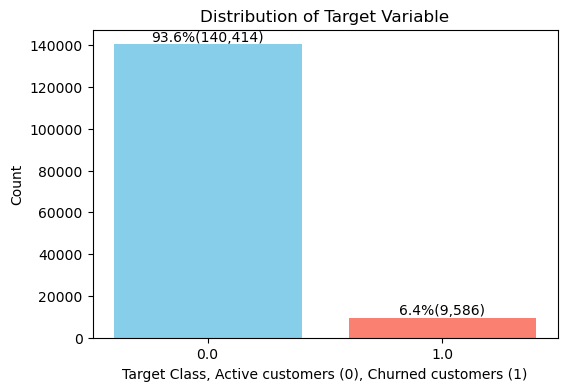

In [15]:
target_col = 'target'

# Calculate value counts and ratios
counts = df_train[target_col].value_counts()
ratios = df_train[target_col].value_counts(normalize=True)

print("Target Variable Distribution:")

plt.figure(figsize=(6,4))
bars = plt.bar(counts.index.astype(str), counts.values, color=['skyblue', 'salmon'])
plt.title('Distribution of Target Variable')
plt.xlabel('Target Class, Active customers (0), Churned customers (1)')
plt.ylabel('Count')

# bars with percentage and counts
for idx, value in enumerate(counts.index):
    plt.text(
        idx, 
        counts[value] + max(counts.values)*0.01, 
        f"{ratios[value]*100:.1f}%({counts[value]:,})",
        ha='center', 
        fontsize=10
    )

plt.show()


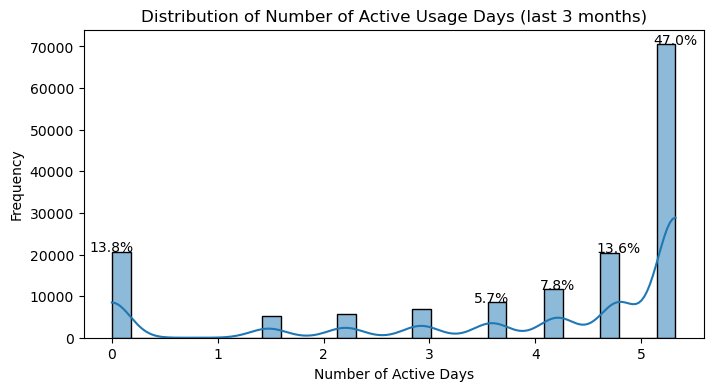

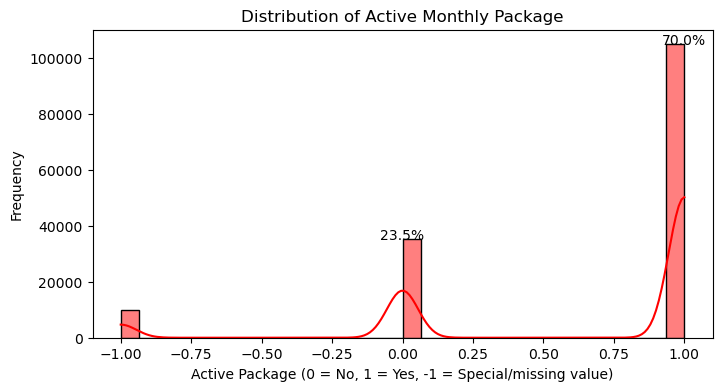

In [16]:

col = 'num_act_days_min_mnt3'
plt.figure(figsize=(8, 4))
sns.histplot(df_train[col], kde=True, bins=30)
plt.title('Distribution of Number of Active Usage Days (last 3 months)')
plt.xlabel('Number of Active Days')
plt.ylabel('Frequency')

# Calculate value ratios for labeling
value_counts = df_train[col].value_counts(normalize=True)
for value, ratio in value_counts.items():
    if ratio > 0.05:  # Only label values with more than 5% frequency
        plt.text(value, df_train[col].value_counts()[value], f'{ratio*100:.1f}%', ha='center')

plt.show()

# For 'active_ppm'
col = 'active_ppm'
plt.figure(figsize=(8, 4))
sns.histplot(df_train[col], kde=True, bins=30, color='red')
plt.title('Distribution of Active Monthly Package')
plt.xlabel('Active Package (0 = No, 1 = Yes, -1 = Special/missing value)')
plt.ylabel('Frequency')

# Calculate and add ratios for 0 and 1
counts = df_train[col].value_counts(normalize=True)
for value in [0, 1]:
    if value in counts:
        plt.text(value, df_train[col].value_counts()[value], f'{counts[value]*100:.1f}%', ha='center')

plt.show()


## 2. Feature engineering and primary selection

In [18]:
print("Removing highly correlated features...")
#df_uncorr, dropped_cols = drop_highly_correlated(df_train, threshold=0.98)

Removing highly correlated features...


In [19]:
df_uncorr = df_train.drop(columns=['voice_in_fix_tar_dur_mea_mnt1', 'voice_in_kievstar_part_max_mnt3', 'voice_mts_out_nrest_partmax_mnt3', 'ama_volume_max_mnt1', 'voice_mts_in_nwork_part_std_mnt3', 'MV_Traf_Cont_inc_v_Min', 'pay_max_max_mnt1', 'data_3g_tv_cnt_min_mnt1', 'voice_out_tar_dur_mea_mnt1', 'voice_out_fix_tar_dur_mea_mnt1', 'MV_ARPU_inc_s_Traf', 'all_roam_clc_std_mnt3', 'vas_clc_max_mnt1', 'voice_in_fix_tar_dur_std_mnt3', 'data_3g_tv_cnt_max_mnt1', 'gprs_clc_max_mnt3', 'block_all_dur_max_mnt1', 'data_3g_dou_mea_mnt1', 'clc_no_vas_roam_max_mnt1', 'DNZ_MEAN_days_closed_loan_year5', 'MV_Traf_Other_inc_v_Min', 'voice_in_life_part_max_mnt1', 'sms_in_cnt_std_mnt3', 'ama_volume_mea_mnt3', 'all_roam_clc_max_mnt3', 'MV_ARPU_innet_inc_v_Traf', 'MV_dou_omo_out_v', 'gprs_clc_std_mnt1', 'voice_in_roam_clc_max_mnt3', 'data_3g_tar_vol_std_mnt3', 'data_3g_tv_cnt_min_mnt3', 'voice_in_roam_clc_max_mnt1', 'voice_in_fix_tar_dur_std_mnt1', 'gprs_clc_max_mnt1', 'MV_ot_total', 'voice_mts_out_nwork_partmax_mnt1', 'block_all_dur_min_mnt3', 'voice_mts_out_nrest_partstd_mnt1', 'MV_ap_pstn_out_v', 'pay_avg_max_mnt1', 'gprs_clc_std_mnt3', 'pay_avg_std_mnt1', 'voice_in_cmpttrs_td_cnt_mea_mnt1', 'pay_max_max_mnt3', 'pay_p2p_in_sum_mea_mnt1', 'pay_p2p_out_sum_min_mnt1', 'MV_ot_R_sm', 'ama_volume_std_mnt3', 'MV_ap_Roam_d', 'MV_ot_Roam_d', 'voice_out_cmpttrs_avg_dumax_mnt3', 'MV_ot_Cont_v', 'gprs_tar_vol_max_mnt1', 'vas_clc_mea_mnt3', 'MV_ot_Unkn', 'pay_sum_max_mnt1', 'data_3g_tv_cnt_max_mnt3', 'sms_clc_max_mnt1', 'sms_out_cnt_std_mnt1', 'pay_p2p_in_sum_std_mnt3', 'sms_out_cnt_max_mnt3', 'content_clc_std_mnt3', 'vas_clc_std_mnt1', 'pay_sum_mea_mnt3', 'voice_out_td_cnt_max_mnt1', 'pay_p2p_in_sum_max_mnt1', 'BS_OVERBUNDLE_MB_CNT_M1', 'MV_ARPU_Other_out_v_Traf', 'voice_out_fix_tar_dur_std_mnt1', 'pay_p2p_in_sum_mea_mnt3', 'device_type_rus_other', 'voice_in_tar_dur_max_mnt1', 'pay_p2p_out_sum_min_mnt3', 'voice_mts_out_nwork_partstd_mnt3', 'MV_ot_R_v', 'MV_ot_inc_v', 'voice_in_fix_tar_dur_max_mnt3', 'sms_out_cnt_max_mnt1', 'voice_out_fix_tar_dur_mea_mnt3', 'vas_clc_std_mnt3', 'sms_clc_mea_mnt1', 'pay_avg_mea_wk1', 'abon_part_mea_mnt3', 'voice_out_cmpttrs_td_cntmax_mnt1', 'conn_com_part_min_mnt3', 'BS_OVERBUNDLE_MB_SUM_M3', 'gprs_tar_vol_mea_mnt1', 'voice_mts_in_nrest_part_max_mnt1', 'voice_out_fix_tar_dur_std_mnt3', 'MV_ot_pstn_out_v', 'pay_p2p_out_sum_mea_mnt1', 'pay_avg_min_mnt1', 'block_all_dur_mea_mnt1', 'MV_DOU_AP', 'abon_part_std_mnt1', 'pay_sum_mea_mnt1', 'abon_part_max_mnt1', 'block_all_dur_max_mnt3', 'content_clc_max_mnt3', 'MV_ot_4G_d', 'DNZ_COUNT_open_loan_year5', 'MV_ap_Cont_v', 'all_clc_std_mnt1', 'gprs_tar_vol_max_mnt3', 'MV_ot_Other', 'DNZ_COUNT_closed_loan_year5', 'non_accum_internet_vol_max_mnt3', 'abon_part_std_mnt3', 'all_home_clc_max_mnt3', 'block_all_dur_mea_wk1', 'MV_ARPU_Other_inc_v_Traf', 'num_act_days_min_mnt3', 'pay_max_min_mnt1', 'accum_oth_dur_max_mnt1', 'voice_out_short_part_std_mnt1', 'voice_in_td_cnt_max_mnt1', 'voice_mts_out_nrest_partmea_mnt1', 'MV_dou', 'sms_roam_clc_mea_mnt3', 'num_act_days_min_mnt1', 'pay_max_std_mnt3', 'pay_max_std_mnt1', 'all_clc_max_mnt1', 'sms_clc_max_mnt3', 'MV_ap_Other', 'all_home_clc_max_mnt1', 'MV_ot_innet_out_v', 'MV_ap_inc_v', 'data_3g_tar_vol_max_mnt3', 'voice_in_roam_clc_std_mnt3', 'BS_OVERBUNDLE_MB_CNT_M2', 'MV_Traf_mn_out_v_Min', 'non_accum_internet_vol_max_mnt1', 'content_clc_max_mnt1', 'data_3g_tar_vol_std_mnt1', 'MV_ap_2G_d', 'voice_in_cmpttrs_avg_durstd_mnt3', 'MV_ap_4G_d', 'pay_max_mea_mnt1', 'pay_p2p_out_sum_std_mnt3', 'sms_roam_clc_std_mnt3', 'data_3g_tar_vol_max_mnt1', 'pay_avg_mea_mnt3', 'all_roam_clc_max_mnt1', 'ama_volume_mea_mnt1', 'accum_oth_dur_max_mnt3', 'MV_Traf_Roam_d_Mb', 'all_home_clc_std_mnt3', 'all_home_clc_std_mnt1', 'sms_out_cnt_mea_mnt3', 'conn_in_uniq_cnt_mea_mnt1', 'all_roam_clc_std_mnt1', 'voice_in_roam_clc_mea_mnt1', 'clc_no_vas_roam_std_mnt1', 'pay_sum_mea_wk1', 'content_clc_std_mnt1', 'voice_mts_in_nrest_part_std_mnt3', 'DNZ_MAX_days_closed_loan_year5', 'voice_in_short_part_std_mnt1', 'voice_in_life_part_max_mnt3', 'voice_in_cmpttrs_td_cnt_std_mnt3', 'sms_clc_mea_mnt3', 'voice_out_cmpttrs_td_cntstd_mnt3', 'gprs_tar_vol_mea_mnt3'])
df_uncorr.shape[1]

605

In [20]:
print(f"\nFeatures before correlation removal: {df_train.shape[1]}")
print(f"Features after correlation removal: {df_uncorr.shape[1]}")
#print(f"Dropped {len(dropped_cols)} highly correlated features")


Features before correlation removal: 769
Features after correlation removal: 605


In [21]:
# Prepare features and target
df = df_uncorr.copy()
X = df.drop(['target', 'abon_id'], axis=1, errors='ignore')
y = df['target']

print(f"Final feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

Final feature matrix shape: (150000, 603)
Target shape: (150000,)


In [22]:
# lets use the StandardScaler
#scaler = StandardScaler()
#df_train_scaled = scaler.fit_transform(df_train)
#df_train_scaled = pd.DataFrame(df_train_scaled, index=df_train.index, columns=df_train.columns)

# FIRST TRAIN

In [24]:
# Split the data into training and testing sets
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set target distribution: {y_train.value_counts().to_dict()}")
print(f"Testing set target distribution: {y_test.value_counts().to_dict()}")

Splitting data into training and testing sets...
Training set shape: (120000, 603)
Testing set shape: (30000, 603)
Training set target distribution: {0.0: 112331, 1.0: 7669}
Testing set target distribution: {0.0: 28083, 1.0: 1917}


In [25]:
# Count classes in your train set
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale_pos_weight = neg / pos
scale_pos_weight

# Dictionary of models to train
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42),
    "CatBoost": CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "LightGBM": LGBMClassifier(is_unbalance=True, random_state=42)
}

# Train each model and evaluate
results = []

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict probabilities and binary outcomes
    prob_pred = model.predict_proba(X_test)[:, 1]
    binary_pred = model.predict(X_test)

    # Calculate metrics
    auc_score = roc_auc_score(y_test, prob_pred)
    recall = recall_score(y_test, binary_pred)
    precision = precision_score(y_test, binary_pred)
    f1 = f1_score(y_test, binary_pred)
    
    # Append results
    results.append({
    "Model": name,
    "AUC-ROC": auc_score,
    "F1": f1,
    "Recall": recall,
    "Precision": precision
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_sorted_df = results_df.sort_values(['AUC-ROC', 'F1', 'Recall'], ascending=(False, False, False))
results_sorted_df

[LightGBM] [Info] Number of positive: 7669, number of negative: 112331
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92346
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 559
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063908 -> initscore=-2.684264
[LightGBM] [Info] Start training from score -2.684264


,Model,AUC-ROC,F1,Recall,Precision
4,LightGBM,0.901252,0.415447,0.777256,0.283486
2,CatBoost,0.899300,0.466816,0.706312,0.348610
1,XGBoost,0.886481,0.450729,0.677621,0.337666
0,Random Forest,0.878825,0.327532,0.215962,0.677578
3,Logistic Regression,0.864833,0.326526,0.775691,0.206786


# Feature importance

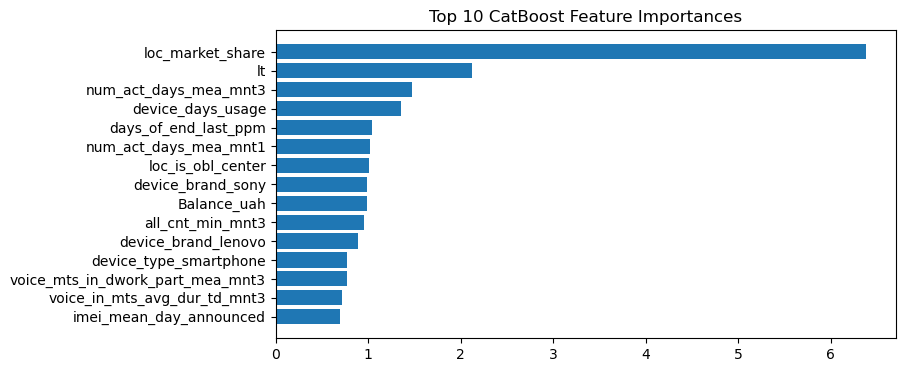

In [27]:
# After training:
catboost_model = models["CatBoost"]

# Feature importance: CatBoost
catboost_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': catboost_model.get_feature_importance()
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 4))
plt.barh(catboost_importance['Feature'].head(15), catboost_importance['Importance'].head(15))
plt.gca().invert_yaxis()
plt.title('Top 10 CatBoost Feature Importances')
plt.show()


In [28]:

print("\nCatBoost Feature Importance (less important):")
print(catboost_importance[catboost_importance['Importance'] <= 0.1])


CatBoost Feature Importance (less important):
                           Feature  Importance
104     conn_out_uniq_cnt_mea_mnt3    0.099827
244  voice_out_short_part_max_mnt3    0.099726
123   voice_in_short_part_max_mnt3    0.099634
235       clc_no_vas_roam_min_mnt1    0.099282
175     conn_out_uniq_cnt_mea_mnt1    0.098061
..                             ...         ...
434     conn_out_uniq_cnt_max_mnt1    0.000000
102      Ama_rchrgmnt_sum_min_mnt3    0.000000
440      Ama_rchrgmnt_sum_min_mnt1    0.000000
101           content_clc_mea_mnt3    0.000000
0        Ama_rchrgmnt_sum_max_mnt1    0.000000

[288 rows x 2 columns]


In [29]:
print("Feature Importance (less important):")
col_to_drop = catboost_importance[catboost_importance['Importance'] <= 0.1]['Feature'].to_list()
df_reduced = df.drop(columns=col_to_drop)
print(f"Dropped {len(col_to_drop)} columns. New shape: {df_reduced.shape}")

Feature Importance (less important):
Dropped 288 columns. New shape: (150000, 317)


In [30]:
X = df_reduced.drop(['target', 'abon_id'], axis=1, errors='ignore')
y = df_reduced['target']

# SNew split
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set target distribution: {y_train.value_counts().to_dict()}")
print(f"Testing set target distribution: {y_test.value_counts().to_dict()}")


Splitting data into training and testing sets...
Training set shape: (120000, 315)
Testing set shape: (30000, 315)
Training set target distribution: {0.0: 112331, 1.0: 7669}
Testing set target distribution: {0.0: 28083, 1.0: 1917}


# Train again on important features

In [32]:
#Train again
model = CatBoostClassifier(auto_class_weights='Balanced', 
                           eval_metric='AUC',
                           iterations=500, 
                           verbose=20, 
                           random_state=42)

model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=10, plot=False, early_stopping_rounds=30)

# Predict probabilities and binary outcomes
prob_pred = model.predict_proba(X_test)[:, 1]
binary_pred = model.predict(X_test)

results_df = evaluate_classification_model(
    y_true=y_test, 
    y_pred_binary=binary_pred, 
    y_pred_proba=prob_pred, 
    model_name='catboost',
)


Learning rate set to 0.13977
0:	test: 0.8413138	best: 0.8413138 (0)	total: 27.7ms	remaining: 13.8s
10:	test: 0.8817105	best: 0.8817105 (10)	total: 284ms	remaining: 12.6s
20:	test: 0.8915978	best: 0.8915978 (20)	total: 540ms	remaining: 12.3s
30:	test: 0.8953196	best: 0.8953196 (30)	total: 787ms	remaining: 11.9s
40:	test: 0.8976419	best: 0.8976419 (40)	total: 1.04s	remaining: 11.7s
50:	test: 0.8991662	best: 0.8991662 (50)	total: 1.32s	remaining: 11.7s
60:	test: 0.9000271	best: 0.9000271 (60)	total: 1.58s	remaining: 11.3s
70:	test: 0.9001630	best: 0.9003464 (63)	total: 1.81s	remaining: 11s
80:	test: 0.9006937	best: 0.9007923 (79)	total: 2.09s	remaining: 10.8s
90:	test: 0.9013607	best: 0.9014487 (89)	total: 2.34s	remaining: 10.5s
100:	test: 0.9014217	best: 0.9014487 (89)	total: 2.58s	remaining: 10.2s
110:	test: 0.9012560	best: 0.9018015 (105)	total: 2.83s	remaining: 9.9s
120:	test: 0.9013372	best: 0.9018015 (105)	total: 3.08s	remaining: 9.63s
130:	test: 0.9009470	best: 0.9018015 (105)	tota

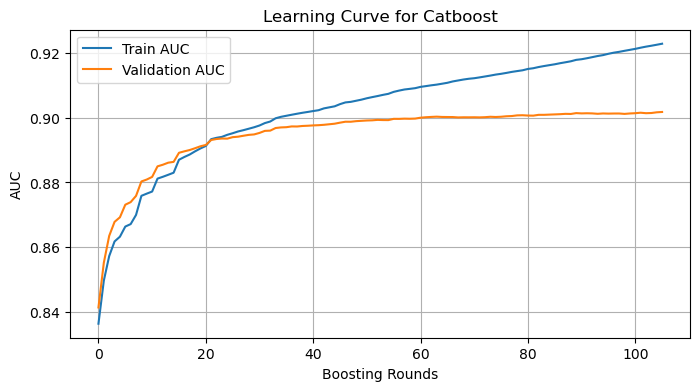

In [33]:

# plot loss on train and validation
plot_learning_curve(model, X_train, y_train, X_test, y_test)


## 4. Model Evaluation

Generating ROC curve comparison...


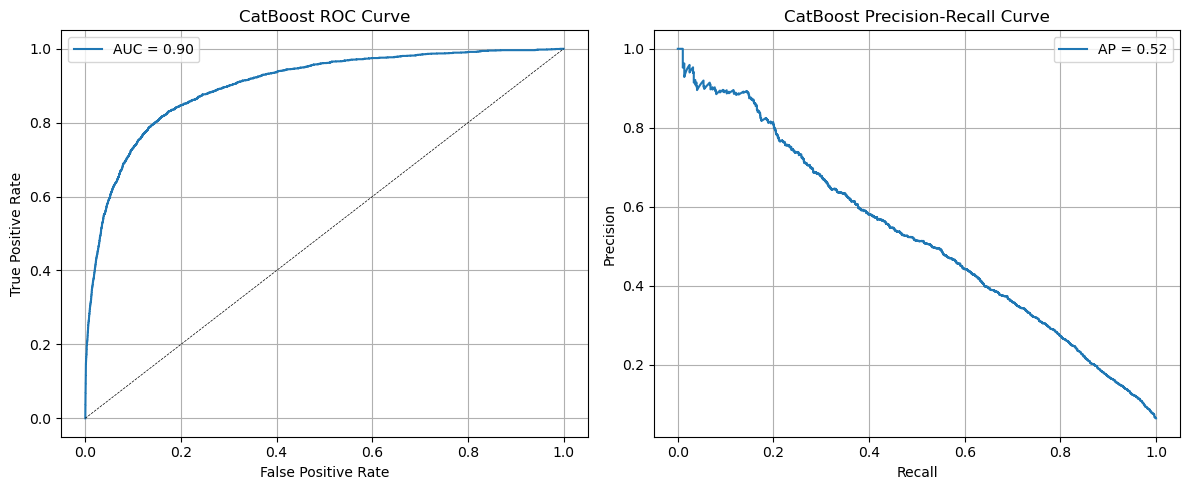

ROC curve analysis completed!


In [35]:
# Plot ROC curves for comparison
print("Generating ROC curve comparison...")

plot_roc_pr_curves(y_test, prob_pred, title_prefix='CatBoost')

print("ROC curve analysis completed!")

Analyzing feature importance...

Top 20 Features:
                             Feature  Importance
0                   loc_market_share   14.991926
1              num_act_days_mea_mnt3    4.234254
2                    device_type_nan    3.598976
3                  device_type_phone    3.347024
4                  device_type_modem    3.016326
5                                 lt    2.959417
6              num_act_days_mea_mnt1    2.770951
7                  loc_is_obl_center    2.718872
8                  device_days_usage    2.116950
9                         active_ppm    1.397445
10                  all_cnt_min_mnt3    1.385086
11                  all_cnt_std_mnt3    1.375491
12                       Balance_uah    1.243001
13                  days_of_last_ppm    1.104200
14          voice_in_tar_dur_mea_wk1    1.029268
15             num_act_days_std_mnt1    0.951006
16        conn_out_uniq_cnt_min_mnt1    0.870035
17         voice_in_tar_dur_std_mnt1    0.839326
18  voice_mts_in_dw

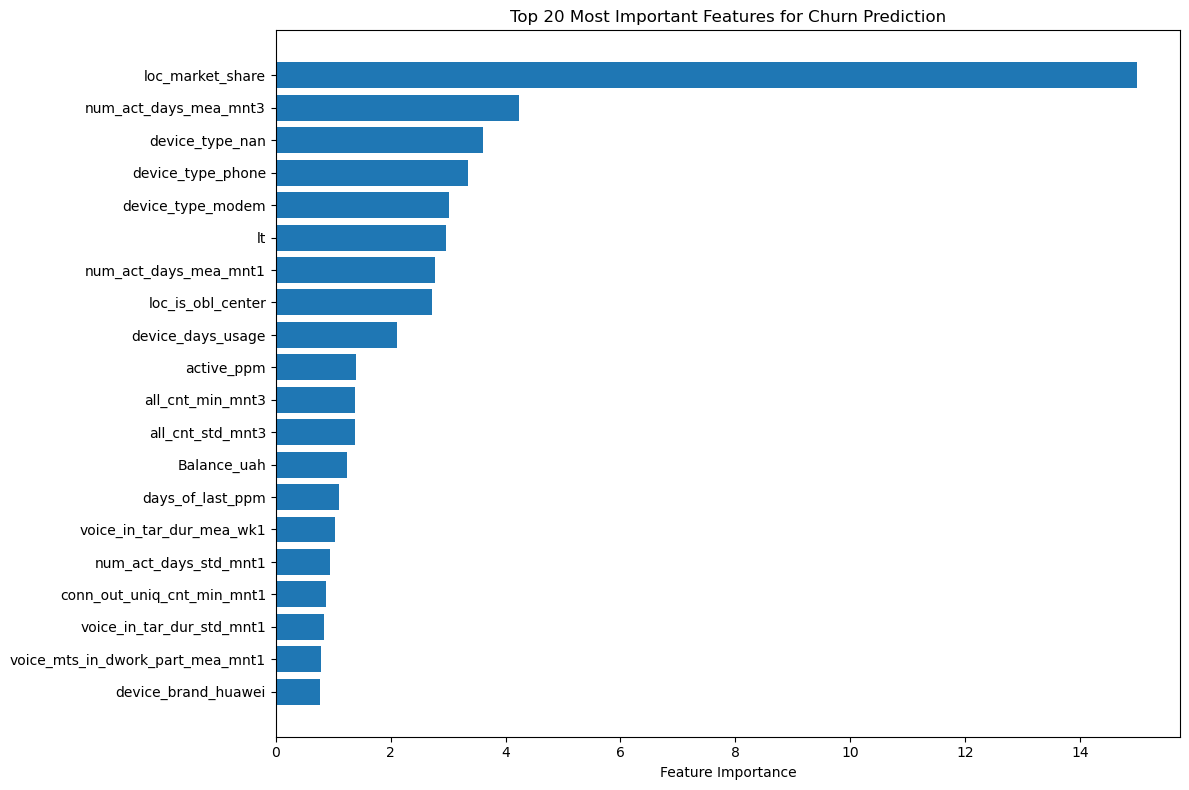

Feature importance analysis completed!


In [36]:
# Analyze feature importance
print("Analyzing feature importance...")

# Get top features and all important features
top_features, important_features = get_features(model, X_train, y_train, top_n=20)

print(f"\nTop 20 most important features identified")
print(f"Total features with importance > 0: {len(important_features)}")

# Visualize top features
feature_importance = pd.DataFrame({
     'Feature': X_train.columns,
     'Importance': model.feature_importances_
 }).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance)), feature_importance['Importance'])
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features for Churn Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Feature importance analysis completed!")

Generating probability distribution plots...


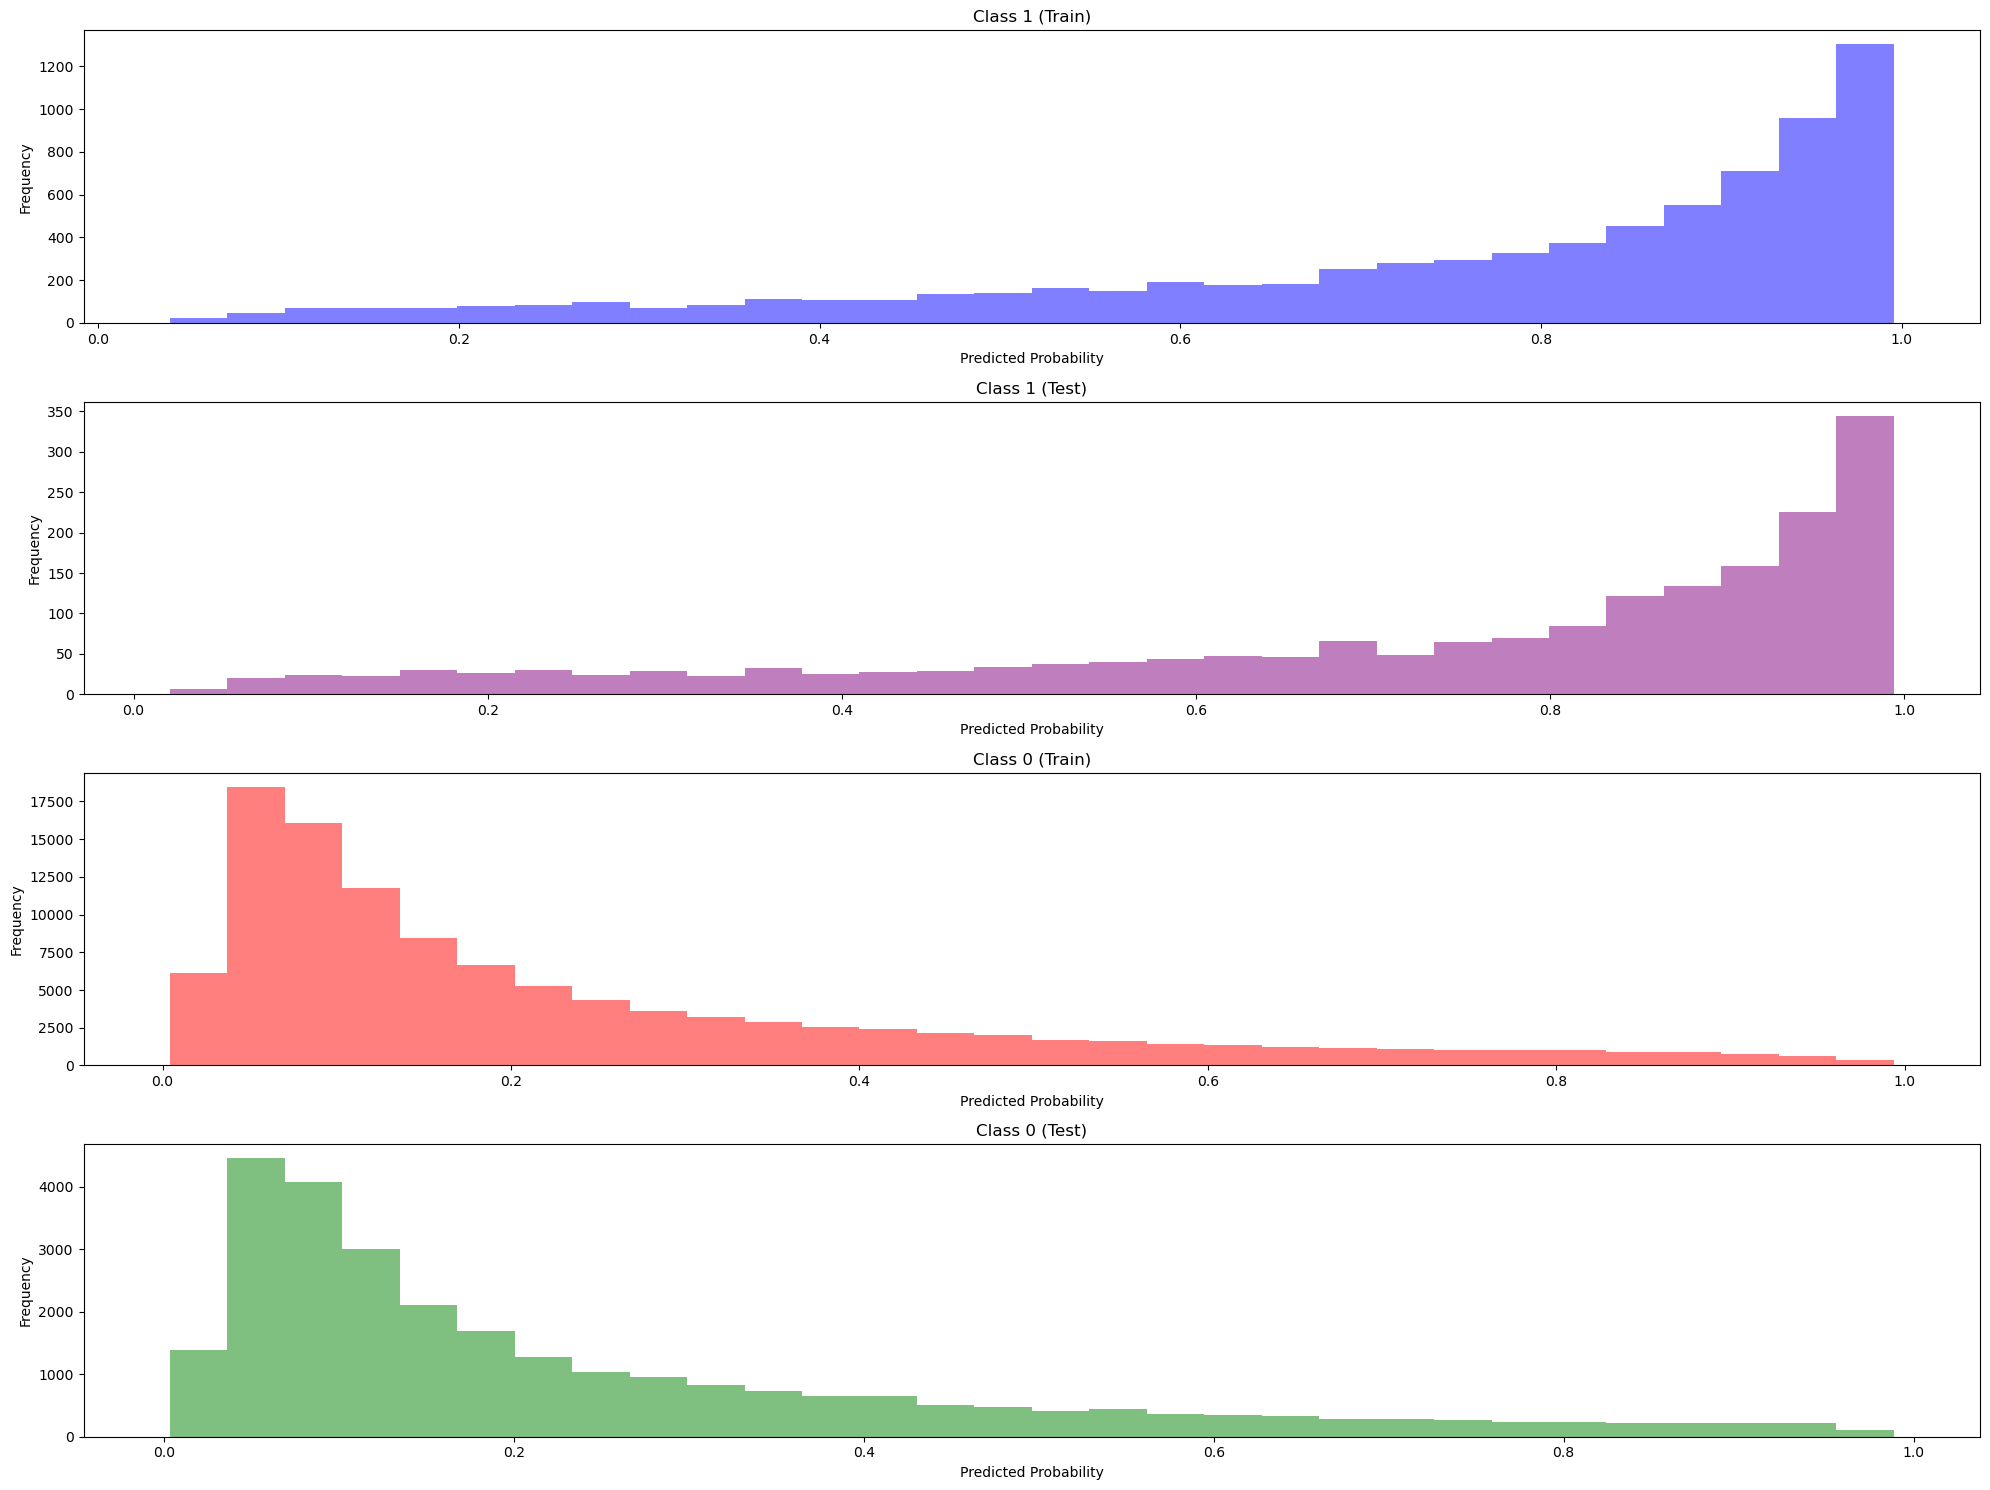

Probability distribution analysis completed!


In [37]:
# Plot probability distributions
print("Generating probability distribution plots...")

# For training data (probability of class 1)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
y_test_pred_proba = model.predict_proba(X_test)[:, 1]


# Get probability predictions for both classes
train_proba_1 = y_train_pred_proba[y_train == 1]
test_proba_1 = y_test_pred_proba[y_test == 1]
train_proba_0 = y_train_pred_proba[y_train == 0]
test_proba_0 = y_test_pred_proba[y_test == 0]

plot_probabilities_hist(train_proba_1, test_proba_1, train_proba_0, test_proba_0)

print("Probability distribution analysis completed!")

## Model Optimization Finding optimal decision threshold

Finding optimal decision threshold...
Optimal threshold value: 0.81
Maximum F1 Score: 0.52


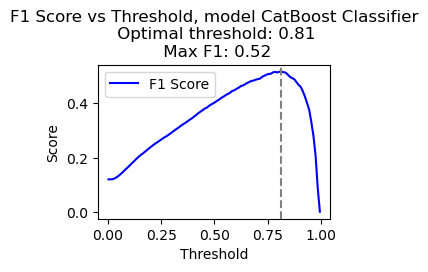

Date and time:  2025-06-26 07:16:35
Threshold optimization completed!


In [39]:
print("Finding optimal decision threshold...")

# Get test predictions for threshold optimization
catboost_test_probs = model.predict_proba(X_test)[:, 1]

# Find optimal threshold on test set (better: use validation set in real projects)
optimal_threshold, max_f1 = calculate_optimal_threshold(y_test, catboost_test_probs)

# Apply optimal threshold to test probabilities to get binary predictions
y_pred_optimal = (catboost_test_probs >= optimal_threshold).astype(int)

print("Threshold optimization completed!")

## Confusion matrix

Generating confusion matrix...


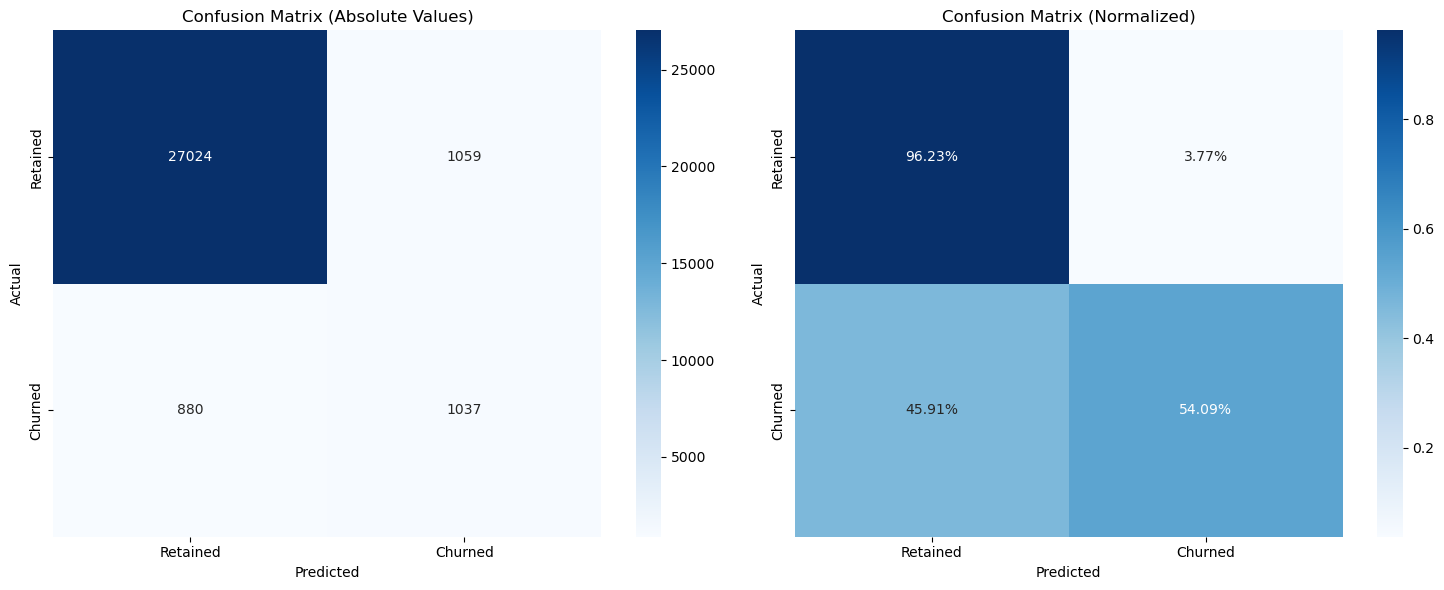


Business Impact Analysis:

True Negatives (Correctly identified retained): 27,024
False Positives (Incorrectly flagged as churn): 1,059
False Negatives (Missed churners): 880
True Positives (Correctly identified churn): 1,037
Confusion matrix analysis completed!


In [41]:
plotting_confusion_matrix(y_test, y_pred_optimal)

In [42]:
print('Model Evaluation')
print(classification_report(y_test, y_pred_optimal))

Model Evaluation
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97     28083
         1.0       0.49      0.54      0.52      1917

    accuracy                           0.94     30000
   macro avg       0.73      0.75      0.74     30000
weighted avg       0.94      0.94      0.94     30000



In [43]:
# Evaluate
results_df = evaluate_classification_model(
    y_true=y_test, 
    y_pred_binary=y_pred_optimal, 
    y_pred_proba=catboost_test_probs, 
    model_name='catboost'
)

## CROSS VALIDATION

In [45]:
# Define the stratified splitter
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define your model
cat = CatBoostClassifier(iterations=106, verbose=0, random_seed=42)

# Use F1 as the scoring metric
scorer = make_scorer(f1_score)

# Perform cross-validation
scores = cross_val_score(cat, X, y, cv=skf, scoring=scorer)

print("F1 scores for each fold:", scores)
print("Average F1 score:", scores.mean())

F1 scores for each fold: [0.41918665 0.44177259 0.44528562 0.44459644 0.44657534]
Average F1 score: 0.4394833282328839


## Final train on all train data

In [47]:
# Train final optimized model
print("Training tuned model...")
final_model = CatBoostClassifier(auto_class_weights='Balanced', 
                                 eval_metric='AUC', 
                                 iterations=106, 
                                 early_stopping_rounds=30,
                                 verbose=10, 
                                 random_seed=42)
final_model.fit(X, y)
print("Final model training completed!")

Training tuned model...
Learning rate set to 0.5
0:	total: 36ms	remaining: 3.78s
10:	total: 368ms	remaining: 3.17s
20:	total: 662ms	remaining: 2.68s
30:	total: 935ms	remaining: 2.26s
40:	total: 1.21s	remaining: 1.92s
50:	total: 1.49s	remaining: 1.61s
60:	total: 1.77s	remaining: 1.3s
70:	total: 2.07s	remaining: 1.02s
80:	total: 2.35s	remaining: 727ms
90:	total: 2.65s	remaining: 437ms
100:	total: 2.93s	remaining: 145ms
105:	total: 3.06s	remaining: 0us
Final model training completed!


## Save the final model

In [49]:

print("Saving the final model...")
save_model(final_model, list(X.columns), optimal_threshold)
print("Model saved successfully!")
print(f"Analysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Saving the final model...
Save CatBoostClassifier_26062025_07_17.pickle
Model saved successfully!
Analysis completed at: 2025-06-26 07:17:32


**Business Impact Reflection**

**This analysis shows how leveraging modern data tools can directly enhance our business outcomes. By running a test campaign, we can measure actual retention rates and assess the financial impact - even when initial costs are incurred. Importantly, as retention success rates exceed 10%, the campaign shifts into profitability, delivering a strong ROI and substantial net gains for the business.**

**It’s also important to remember that retaining an existing client is up to six times less expensive than acquiring a new one, underscoring the value of investing in effective retention strategies.**